In [54]:
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau,ModelCheckpoint
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import os

In [55]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/handwritten-mongolian-cyrillic-characters-database/HMCC letters merged.csv
/kaggle/input/handwritten-mongolian-cyrillic-characters-database/HMCC similar merged.csv
/kaggle/input/handwritten-mongolian-cyrillic-characters-database/HMCC balanced.csv
/kaggle/input/handwritten-mongolian-cyrillic-characters-database/HMCC all.csv


In [56]:
# HMCC letters: It contains 183750 samples of 35 classes.
data = pd.read_csv('/kaggle/input/handwritten-mongolian-cyrillic-characters-database/HMCC letters merged.csv')

In [57]:
data = data.to_numpy()

In [58]:
x,y = data[:,1:], data[:,0]

In [59]:
class mmnist(Dataset):
    def __init__(self, x, y, transform=None):
        self.x = x
        self.y = y
        self.transform = transform
    def __len__(self):
        return len(self.x)
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [60]:
X_train, y_train = x[:int(len(x)*0.7)], y[:int(len(y)*0.7)]
X_test, y_test = x[int(len(x)*0.7):], y[int(len(y)*0.7):]

In [61]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(128624, 784)
(55125, 784)
(128624,)
(55125,)


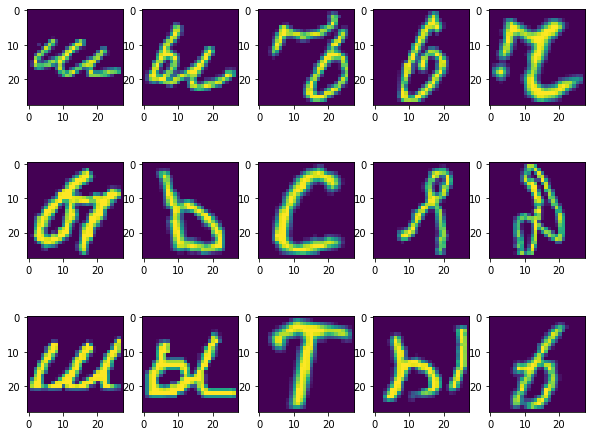

In [62]:
fig,axes = plt.subplots(3,5,figsize=(10,8))
for i,ax in enumerate(axes.flat):
    ax.imshow(X_train[i].reshape([28,28]))

# Preporcessing

## 1. Normalisation and reshaping of data

In [63]:
train_img = X_train / 255.0
test_img = X_test / 255.0

train_img_number = train_img.shape[0]
train_img = train_img.reshape(train_img_number, 28, 28, 1)

test_img_number = test_img.shape[0]
test_img = test_img.reshape(test_img_number, 28, 28, 1)

In [64]:
# Transform labels 
number_of_classes = 35

y_train = tf.keras.utils.to_categorical(y_train, number_of_classes)
y_test = tf.keras.utils.to_categorical(y_test, number_of_classes)

# CNN classification

In [65]:
model = tf.keras.Sequential([ 
    tf.keras.layers.Conv2D(32,3,input_shape=(28,28,1)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(input_shape=(28,28,1)),
    tf.keras.layers.Dense(512,activation='relu'),
    tf.keras.layers.Dense(128,activation='relu'),
    tf.keras.layers.Dense(number_of_classes,activation='softmax')
])

In [66]:
model.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])

In [67]:
# train_x,test_x,train_y,test_y = train_test_split(train_img,y_train,test_size=0.2,random_state = 42)
train_x,test_x,train_y,test_y = train_test_split(train_img,y_train,test_size=0.15,random_state = 42)

In [68]:
MCP = ModelCheckpoint('Best_points.h5',verbose=1,save_best_only=True,monitor='val_accuracy',mode='max')
ES = EarlyStopping(monitor='val_accuracy',min_delta=0,verbose=0,restore_best_weights = True,patience=3,mode='max')
RLP = ReduceLROnPlateau(monitor='val_loss',patience=3,factor=0.2,min_lr=0.0001)

In [69]:
history = model.fit(train_x,train_y,epochs=10,validation_data=(test_x,test_y), callbacks=[MCP,ES,RLP])

Epoch 1/10
3417/3417 [==============================] - 13s 4ms/step - loss: 0.7892 - accuracy: 0.7689 - val_loss: 0.4945 - val_accuracy: 0.8566

Epoch 00001: val_accuracy improved from -inf to 0.85659, saving model to Best_points.h5
Epoch 2/10
3417/3417 [==============================] - 14s 4ms/step - loss: 0.3676 - accuracy: 0.8901 - val_loss: 0.4628 - val_accuracy: 0.8689

Epoch 00002: val_accuracy improved from 0.85659 to 0.86887, saving model to Best_points.h5
Epoch 3/10
3417/3417 [==============================] - 12s 4ms/step - loss: 0.2540 - accuracy: 0.9243 - val_loss: 0.4715 - val_accuracy: 0.8735

Epoch 00003: val_accuracy improved from 0.86887 to 0.87348, saving model to Best_points.h5
Epoch 4/10
3417/3417 [==============================] - 12s 4ms/step - loss: 0.2004 - accuracy: 0.9403 - val_loss: 0.5296 - val_accuracy: 0.8831

Epoch 00004: val_accuracy improved from 0.87348 to 0.88312, saving model to Best_points.h5
Epoch 5/10
3417/3417 [==============================] -

### Accuracy vs Val_Accuracy to further evaluation..

Text(0, 0.5, 'Accuray')

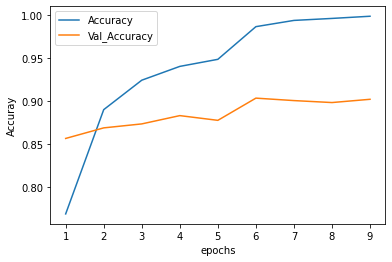

In [70]:
import seaborn as sns
q = len(history.history['accuracy'])

plt.figsize=(10,10)
sns.lineplot(x = range(1,1+q),y = history.history['accuracy'], label='Accuracy')
sns.lineplot(x = range(1,1+q),y = history.history['val_accuracy'], label='Val_Accuracy')
plt.xlabel('epochs')
plt.ylabel('Accuray')